In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.ensemble as skl_en
import sklearn.model_selection as skl_ms
import sklearn.metrics as skl_met
import sklearn.preprocessing as skl_pre

In [36]:
rawData = pd.read_csv('train.csv')

In [37]:
data = rawData.copy()
data['Lead'] = pd.get_dummies(data['Lead'])

In [38]:
cols_to_norm = [
    'Total words',
    'Year',
    'Gross',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Number of actors'#,
    #'Proportion of words lead',
    #'Proportion of words co-lead',
    #'Ratio words co-lead lead',
    #'Proportion of words female',
    #'Proportion of female actors',
]

In [39]:
def pre_process(raw_data, cols_to_norm):
    data = raw_data.copy()
    
    data['Lead'] = pd.get_dummies(data['Lead'])
    data['Number of words co-lead'] = data['Number of words lead'] - data['Difference in words lead and co-lead']
    data['Proportion of words lead'] = data['Number of words lead']/data['Total words']
    data['Proportion of words co-lead'] = data['Number of words co-lead']/data['Total words']
    data['Ratio words co-lead lead'] = data['Number of words co-lead']/data['Number of words lead']
    data['Proportion of words female'] = data['Number words female']/(data['Total words'] - data['Number of words lead'])
    data['Number of actors'] = data['Number of male actors'] + data['Number of female actors']
    data['Proportion of female actors'] = data['Number of female actors']/data['Number of actors']
    data['Older lead'] = data['Age Lead'] < data['Age Co-Lead']
    data['Older lead'] = pd.get_dummies(data['Older lead'])
    
    scaler = skl_pre.StandardScaler()
    data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])
    
    return data

In [40]:
def fit_and_test(classifier, train, test, features, target, suppress_output = False):
    classifier.fit(train[features], train[target])
    if not suppress_output:
        skl_met.plot_roc_curve(classifier, test[features], test[target])
        print('accuracy: ' + str(classifier.score(test[features], test[target])))
        print('     auc: ' + str(skl_met.roc_auc_score(test[target], classifier.predict_proba(test[features])[:,1])) + '\n')
        print(skl_met.classification_report(test[target], classifier.predict(test[features])))
    return classifier

In [41]:
features = [
    'Year',
    'Gross',
    'Number of actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Ratio words co-lead lead',
    'Proportion of words female',
    'Older lead'
]
target = 'Lead'

In [42]:
data = pre_process(rawData, cols_to_norm)

In [43]:
config = pd.read_csv('config.csv')
trainRatio = config['Train Ratio'][0]
seed = config['Random Seed'][0]
train, test = skl_ms.train_test_split(data, train_size=trainRatio) #, random_state=seed)

## Random forest (bagging)

accuracy: 0.9134615384615384
     auc: 0.9260061919504644

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        85
           1       0.92      0.58      0.71        19

    accuracy                           0.91       104
   macro avg       0.91      0.78      0.83       104
weighted avg       0.91      0.91      0.91       104



RandomForestClassifier()

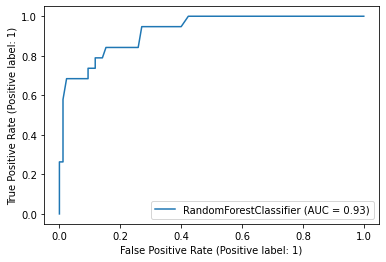

In [44]:
fit_and_test(skl_en.RandomForestClassifier(), train, test, features, target)

In [46]:
%%time
B = 100
accuracies = []
aucs = []
for i in range(B):
    train, test = skl_ms.train_test_split(data, train_size=trainRatio)
    forest = fit_and_test(skl_en.RandomForestClassifier(), train, test, features, target, suppress_output=True)
    accuracies.append(forest.score(test[features], test[target]))
    aucs.append(skl_met.roc_auc_score(test[target], forest.predict_proba(test[features])[:,1]))

CPU times: user 18.2 s, sys: 58.9 ms, total: 18.3 s
Wall time: 18.3 s


In [47]:
print('mean accuracy: ' + str(np.mean(accuracies)))
print('     mean auc: ' + str(np.mean(aucs)))

mean accuracy: 0.9023076923076924
     mean auc: 0.9464823074276127


## Gradient Boosted Trees

accuracy: 0.9423076923076923
     auc: 0.9721362229102167

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        85
           1       0.88      0.79      0.83        19

    accuracy                           0.94       104
   macro avg       0.92      0.88      0.90       104
weighted avg       0.94      0.94      0.94       104



GradientBoostingClassifier()

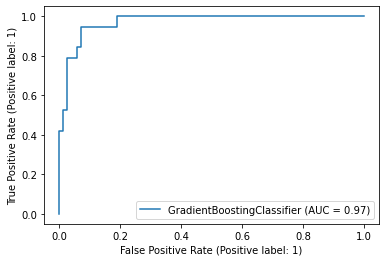

In [45]:
fit_and_test(skl_en.GradientBoostingClassifier(), train, test, features, target)

In [48]:
%%time
B = 100
accuracies = []
aucs = []
for i in range(B):
    train, test = skl_ms.train_test_split(data, train_size=trainRatio)
    boostTrees = fit_and_test(skl_en.GradientBoostingClassifier(), train, test, features, target, suppress_output=True)
    accuracies.append(boostTrees.score(test[features], test[target]))
    aucs.append(skl_met.roc_auc_score(test[target], boostTrees.predict_proba(test[features])[:,1]))

CPU times: user 22.5 s, sys: 31.6 ms, total: 22.5 s
Wall time: 22.6 s


In [49]:
print('mean accuracy: ' + str(np.mean(accuracies)))
print('     mean auc: ' + str(np.mean(aucs)))

mean accuracy: 0.9300961538461539
     mean auc: 0.9693151156410258
